In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os 
from scipy import stats
from pypet import Environment, Trajectory, cartesian_product

%matplotlib inline

with open('data_path.txt', 'r') as f:
    data_path = f.readline()

hdf_path = os.path.join(data_path, 'HDF')
    
exp_data = pd.read_csv(os.path.join(data_path, 'virtual_stick\passive_phases.csv'), header=0)

# Experimental data overview

In [2]:
def plot_pdf(data, var, ax=None, ls='-', by_subj=True):
    subjects = np.arange(1, 11)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if by_subj:
        for subject in subjects:
            x = data.loc[data.subject==subject, var]
            hist, bins = np.histogram(x, bins=20, normed=True)
            hist[hist==0] = np.nan
            ax.plot((bins[1:] + bins[:-1])/2, hist, label=subject, ls=ls, alpha=0.8)
    else:
        x = data.loc[:, var]
        hist, bins = np.histogram(x, bins=30, normed=True)
        # only plot bins with 5 or more data points
        hist[hist<4/len(x)] = np.nan
        ax.plot((bins[1:] + bins[:-1])/2, hist, ls=ls, alpha=0.5, color='k')
    
    ax.set_ylabel('pdf')
    ax.set_yscale('log')
    ax.set_ylim((0.005, 25))

    return ax

What we need to model is the action point (AP) distribution given the starting point (SP) distribution

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


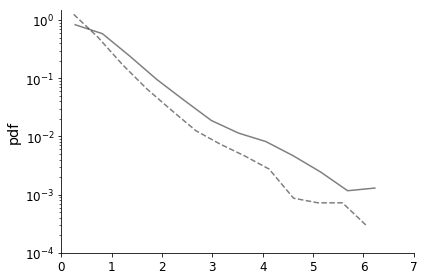

In [3]:
def overlay_exp_data(exp_data, ax):
    ax = plot_pdf(exp_data, 'sp_scaled', by_subj=False, ls='--', ax=ax)
    ax = plot_pdf(exp_data, 'ap_scaled', by_subj=False, ax=ax)
    ax.set_xlim((0.0, 7))
    ax.set_ylim((0.0001, 1.5))
    return ax
    
ax = overlay_exp_data(exp_data, plt.figure().gca())
# ax.set_yscale('linear')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


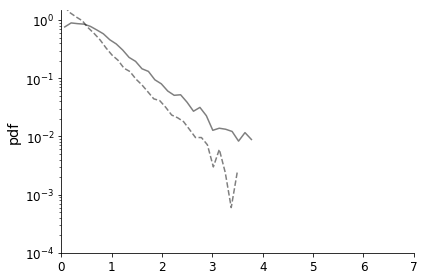

In [8]:
ax = overlay_exp_data(exp_data[exp_data.ap_scaled<exp_data.ap_scaled.quantile(0.99)], plt.figure().gca())

# 2D distributions

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


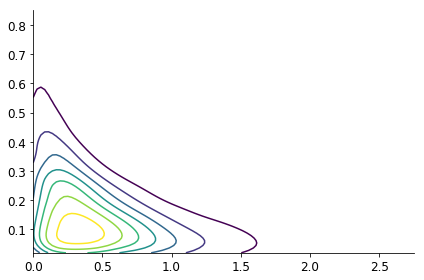

In [4]:
m1, m2 = exp_data.sp_scaled, exp_data.delta_t

[xmin, xmax] = m1.quantile([0.0, 0.99])
[ymin, ymax] = m2.quantile([0.0, 0.99])

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([m1, m2])

pdf = stats.gaussian_kde(values)
Z = np.reshape(pdf(positions).T, X.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(X, Y, Z)
# ax.clabel(CS, inline=1, fontsize=8)
# ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
#           extent=[xmin, xmax, ymin, ymax])
# ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax]);

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


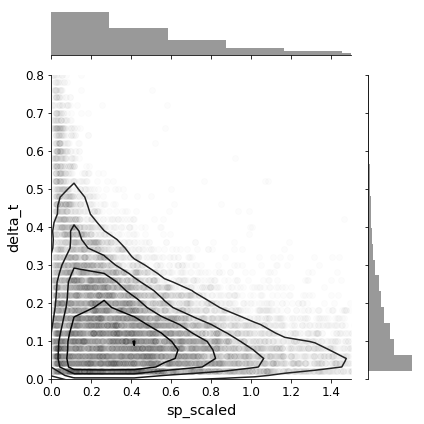

In [5]:
def plot_pdf(data, var, ax=None, ls='-', by_subj=True):
    subjects = np.arange(1, 11)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if by_subj:
        for subject in subjects:
            x = data.loc[data.subject==subject, var]
            hist, bins = np.histogram(x, bins=20, normed=True)
            hist[hist==0] = np.nan
            ax.plot((bins[1:] + bins[:-1])/2, hist, label=subject, ls=ls, alpha=0.8)
    else:
        x = data.loc[:, var]
        hist, bins = np.histogram(x, bins=30, normed=True)
        # only plot bins with 5 or more data points
        hist[hist<4/len(x)] = np.nan
        ax.plot((bins[1:] + bins[:-1])/2, hist, ls=ls, alpha=0.5, color='k')
    
    ax.set_ylabel('pdf')
    ax.set_yscale('log')
    ax.set_ylim((0.005, 25))

    return ax

(sns.jointplot(data=exp_data, x='sp_scaled', y='delta_t', alpha=0.01, xlim=(0, 1.5), ylim=(0, 0.8), color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

# Model analysis for one parameter set

In [20]:
def plot_ddm_traces(xs, ns):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.despine()

    for n in ns:
        ax.plot(xs.loc[n].t, xs.loc[n].x, color='C0')
#     plt.title('Hit rate %.2f' % (xs.hit.mean()))
    return ax

Now let's try to make $A$ non-stationary: $A=\theta(t)$, $dx = \theta(t)dt + c\xi\sqrt{dt}$

In [38]:
def dx(A, c, dt):
    return A*dt + c*np.random.randn()*np.sqrt(dt)

# stimulus strength increases exponentially
def dtheta(theta, tau, dt):
    return theta*dt/tau
    
def run_trial(c, b, ic, tau):
    dt = min(c,b)/50
    t = [0]
    thetas = [ic]
    x = [0]
    
    while x[-1] < b:
        theta = thetas[-1] + dtheta(thetas[-1], tau, dt)
        thetas.append(theta)
        
        t.append(t[-1] + dt)        
        x.append(x[-1] + dx(theta, c, dt))
        
    return np.array(t), np.array(x), np.array(thetas)

def run_sim(c, b, theta_0, tau, n_trials, exp_data):
#     data = pd.read_csv('passive_phases.csv', header=0)
    trials = []
    for n in range(n_trials):
        if theta_0 == 'random':
            ic = random.choice(exp_data.sp_scaled)
        elif theta_0 == 'uniform':
            ic = random.random()
        else:
            ic = theta_0   
        t, x, theta = run_trial(c, b, ic, tau)
        hit = (x[-1]>0)
        # In case of two thresholds (-b and b), hit is set to True if the positive boundary was reached
        # we'd need hit rate close to 1 if we are to capture activation of actual movement
        # based on experimental data, extremely few movements are in the wrong direction
        trials.append(pd.DataFrame(data={'n': n, 't': t, 'x': x, 'theta': theta, 'hit': hit}))
    return pd.concat(trials).set_index(['n'])

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


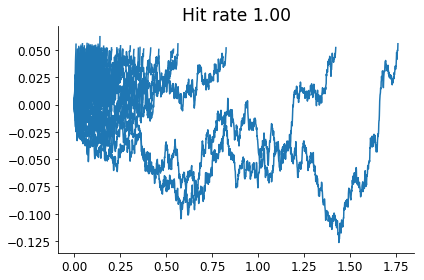

In [21]:
c = 0.1
b = 0.05

# theta_0 = 0.001
theta_0 = 'random'
tau = 1

xs = run_sim(c=c, b=b, theta_0=theta_0, tau=tau, n_trials=5000, exp_data = exp_data)

ns=range(1, 101)
ax = plot_ddm_traces(xs, ns)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


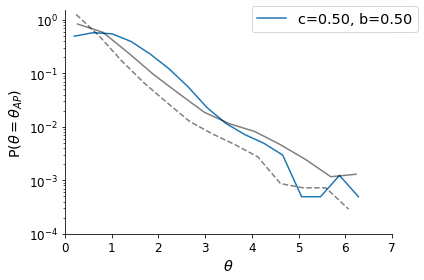

In [27]:
c = 0.5
b = 0.5
# dt = 0.005

theta_0 = 'random'
# theta_0 = 'uniform'
tau = 1

xs = run_sim(c=c, b=b, theta_0=theta_0, tau=tau, n_trials=10000, exp_data=exp_data)

ap = xs[xs.hit].groupby('n').last().theta

ax = plt.figure().gca()

hist, bins = np.histogram(ap, bins=20, normed=True)
hist[hist<4/len(ap)] = np.nan
ax.plot((bins[1:] + bins[:-1])/2, hist, label='c=%.2f, b=%.2f' % (c, b))
overlay_exp_data(exp_data, ax)

ax.legend(bbox_to_anchor=(1.1, 1.05)) 

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'P($\theta=\theta_{AP}$)');

# plt.title('Hit rate %.2f' % (xs.hit.mean()))

It seems that by varying $c$, $b$, and $\tau$ we can get quite different distibutions of action points. Of these parameters, we can fix $\tau$ at 1, and play with c and threshold

# Parameter exploration (DDM)

In [75]:
def run_ddm(traj, exp_data):
    xs = run_sim(c=traj.c, b=traj.b, theta_0=traj.theta_0, tau=traj.tau, n_trials=10000, exp_data=exp_data)
    sp = xs.groupby('n').first().theta
    ap = xs.groupby('n').last().theta
    delta_t = xs.groupby('n').last().t - xs.groupby('n').first().t 
    
    traj.f_add_result('sp', sp, comment='Starting points')
    traj.f_add_result('ap', ap, comment='Action points')
    traj.f_add_result('delta_t', delta_t, comment='Inter-adjustment interval')
    traj.f_add_result('hit', xs.hit.mean(), comment='Hit rate')

In [76]:
c_grid = [0.2, 0.4, 0.6, 0.8]
b_grid = [0.2, 0.4, 0.6, 0.8]

def explore(theta_0, hdf_path, exp_data):    
    env = Environment(trajectory='DDM_AP', filename=hdf_path, file_title='DDM_AP', overwrite_file=True)

    traj = env.trajectory

    traj.f_add_parameter('c', 1.0, comment='Diffusion rate')
    traj.f_add_parameter('b', 1.0, comment='DDM decision boundary')
    traj.f_add_parameter('theta_0', theta_0, comment='Initial condition on theta')
    traj.f_add_parameter('tau', 0.3, comment='Time scale of theta')

    traj.f_explore(cartesian_product({'c':c_grid, 'b':b_grid}))
    env.run(lambda traj: run_ddm(traj, exp_data=exp_data))
    
explore(theta_0='random', hdf_path=os.path.join(hdf_path, '%s.hdf5' % ('ddm_stick_ap_random_sp')), exp_data=exp_data)
# explore('ddm_stick_ap_uniform_sp', theta_0='uniform', data_path=data_path, exp_data=exp_data)
# explore('ddm_stick_ap_fixed_sp', theta_0=0.5, data_path=data_path, exp_data=exp_data)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_stick_ap_random_sp.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     You specified ``overwrite_file=True``, so I deleted the file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_stick_ap_random_sp.hdf5`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `DDM_AP`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `DDM_AP`.
MainProcess pypet.environment.Environment INFO     
*********************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `config`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished storing Trajectory `DDM_AP`.
MainProcess pypet.environment.Environment INFO     
************************************************************
FINISHED FINAL STORING of trajectory
`DDM_AP`.
************************************************************

MainProcess pypet.environment.Environment INFO     All runs of trajectory `DDM_AP` were completed successfully.


# Comparing model to data

In [77]:
from scipy.stats import gaussian_kde

def get_model_pdf(model_data, bandwidth=0.2):
    kde = gaussian_kde(model_data, bw_method=bandwidth / model_data.std(ddof=1))
    return kde.evaluate

def get_log_likelihood(model_pdf, exp_data):
    min_p = 1/len(exp_data)    
    exp_data_probs = model_pdf(exp_data)
    exp_data_probs[exp_data_probs<min_p] = min_p
    return np.log(exp_data_probs).sum()

Let's try plotting exp vs model data in the individual panels

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_stick_ap_random_sp.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `DDM_AP`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `2`.
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnin

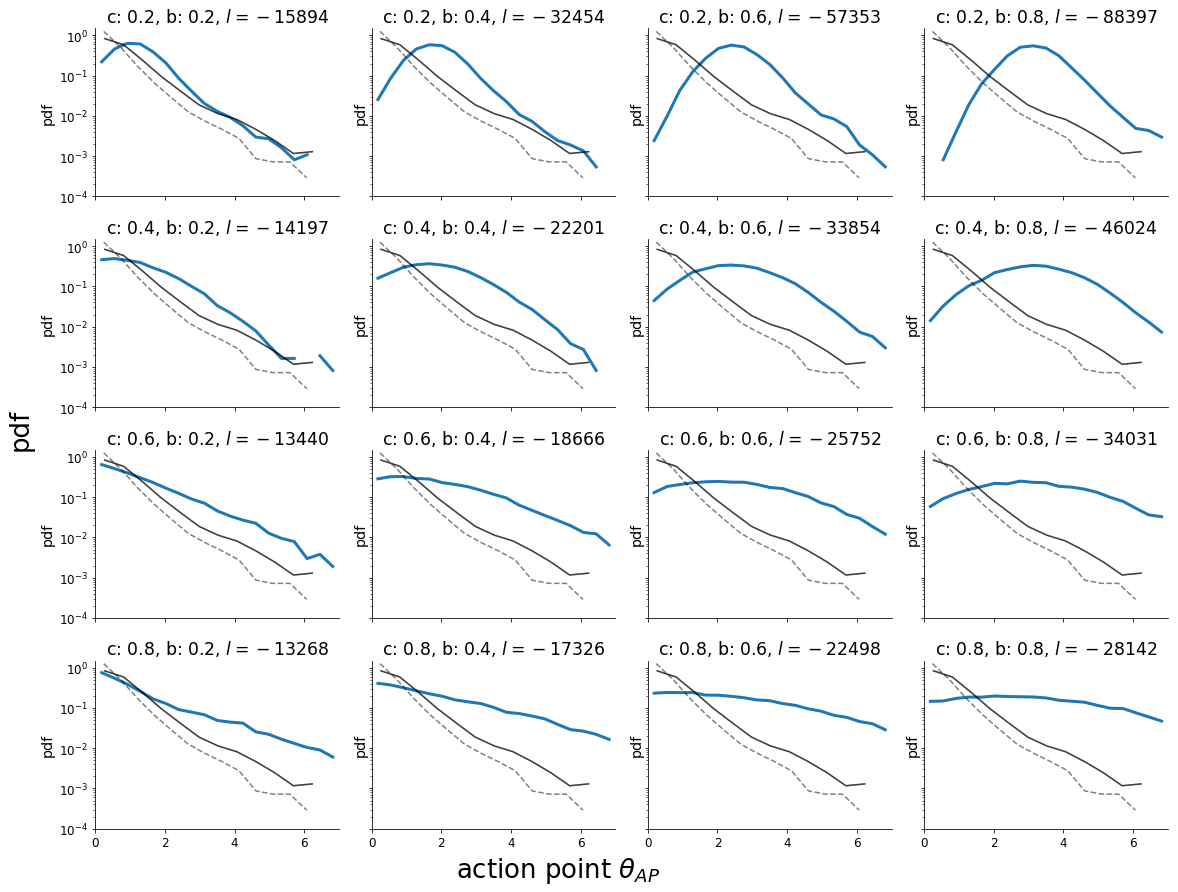

In [79]:
def plot_explore(filename, exp_data, grid):
    traj = Trajectory('DDM_stick')
    traj.f_load(filename=filename, index=-1, load_parameters=2, load_results=2)

    fig, axes = plt.subplots(grid, grid, figsize=(4*(grid),3*(grid)), sharex=True, sharey=True)
    bins=np.linspace(0,7,20)
    exp_hist, _ = np.histogram(exp_data.ap_scaled, bins=bins, normed=True)
    exp_hist[exp_hist<4/len(exp_data.ap_scaled)] = np.nan
    
    for i, ax in enumerate(axes.reshape(-1)):        
        run = traj.f_get_run_names()[i]
        model_data = traj[run]
        
        model_hist, _ = np.histogram(model_data.ap, bins=bins, normed=True)
        model_hist[model_hist<4/len(model_data.ap)] = np.nan        
        
        model_pdf = get_model_pdf(model_data.ap)
        log_lik = get_log_likelihood(model_pdf, exp_data.ap_scaled)
        
#         delta = abs(np.log(exp_hist) - np.log(model_hist))
#         f = ('%.3f' % (np.nanmean(delta[~np.isinf(delta)]))) if (np.mean(np.isinf(delta) | np.isnan(delta)) < 0.5) else 'N/A'
        f = '%.0f' % (log_lik)
        
        ax.plot((bins[1:] + bins[:-1])/2, model_hist, lw=3.0)
        overlay_exp_data(exp_data, ax)
        ax = plot_pdf(exp_data, 'ap_scaled', by_subj=False, ax=ax)
        ax.set_xlim((0.0, 7))
        ax.set_ylim((0.0001, 1.5))
        
        title = (traj.f_get_run_information(run)['parameter_summary'] + r', $l=%s$' % f).replace("  ", "")
        ax.set_title(title, )
#         ax.set_yscale('linear')
            
    fig.text(0.37, -0.02, r'action point $\theta_{AP}$', fontsize=26)
    fig.text(-0.02, 0.5, r'pdf', fontsize=26, rotation=90)
    plt.tight_layout()
    plt.savefig('%s.png' % (filename), bbox_inches='tight')

# plot_explore('ddm_ap_fixed_sp', 4)
# plot_explore('ddm_ap_uniform_sp', 4)
plot_explore(os.path.join(hdf_path, 'ddm_stick_ap_random_sp.hdf5'), exp_data, 4)

# Fitting based on joint starting point and $\Delta_t$ distribution

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


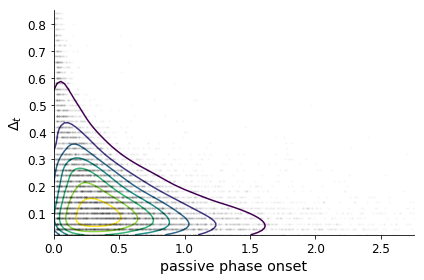

In [12]:
def plot_2d_hist(var1, var2, ax, show_data=False, show_pdf=True, cmap='viridis'):
    values = np.vstack([var1, var2])

    [xmin, xmax] = var1.quantile([0.0, 0.99])
    [ymin, ymax] = var2.quantile([0.0, 0.99])

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    pdf = stats.gaussian_kde(values)
    Z = np.reshape(pdf(positions).T, X.shape)
    if show_pdf:
        CS = ax.contour(X, Y, Z, cmap=cmap)
    
    if show_data:
        ax.plot(var1, var2, 'k.', markersize=3, alpha=0.02)
        
    ax.set_xlabel('passive phase onset')
    ax.set_ylabel('$\Delta_t$')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    return ax
    
var1, var2 = exp_data.sp_scaled, exp_data.delta_t

fig = plt.figure()
ax = fig.add_subplot(111)
    
plot_2d_hist(var1, var2, ax, show_data=True)

In [7]:
traj = Trajectory('DDM_stick')
traj.f_load(filename=os.path.join(hdf_path, 'ddm_stick_ap_random_sp.hdf5'), index=-1, load_parameters=2, load_results=2)

# fig, axes = plt.subplots(grid, grid, figsize=(4*(grid),3*(grid)), sharex=True, sharey=True)

# for i, ax in enumerate(axes.reshape(-1)):        
run = traj.f_get_run_names()[0]
model_data = traj[run]

In [13]:
def get_model_pdf(model_data, bandwidth=0.2):
    var1, var2 = model_data.sp, model_data.delta_t    
    kde = stats.gaussian_kde(np.vstack([var1, var2]))    
    return kde.evaluate

def get_log_likelihood(model_pdf, exp_data):
    var1, var2 = exp_data.sp_scaled, exp_data.delta_t
    min_p = 1/len(exp_data)
    exp_data_probs = model_pdf(np.vstack([var1, var2]))
    exp_data_probs[exp_data_probs<min_p] = min_p
    return np.log(exp_data_probs).sum()

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


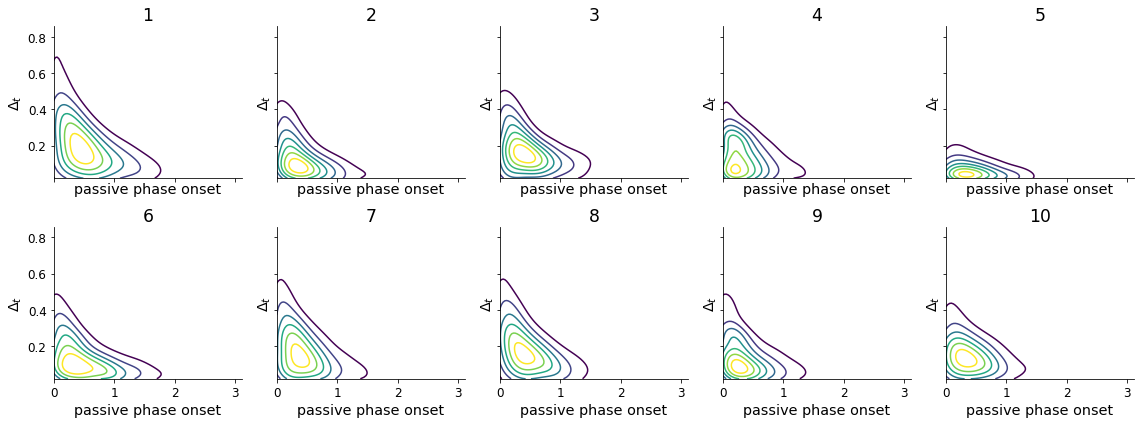

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(16,6), sharex=True, sharey=True)
for i in np.arange(1, 11):
    subj_data = exp_data[exp_data.subject==i]
    ax = axes.reshape(-1)[i-1]
    ax.set_title(i)
    plot_2d_hist(subj_data.sp_scaled, subj_data.delta_t, ax)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


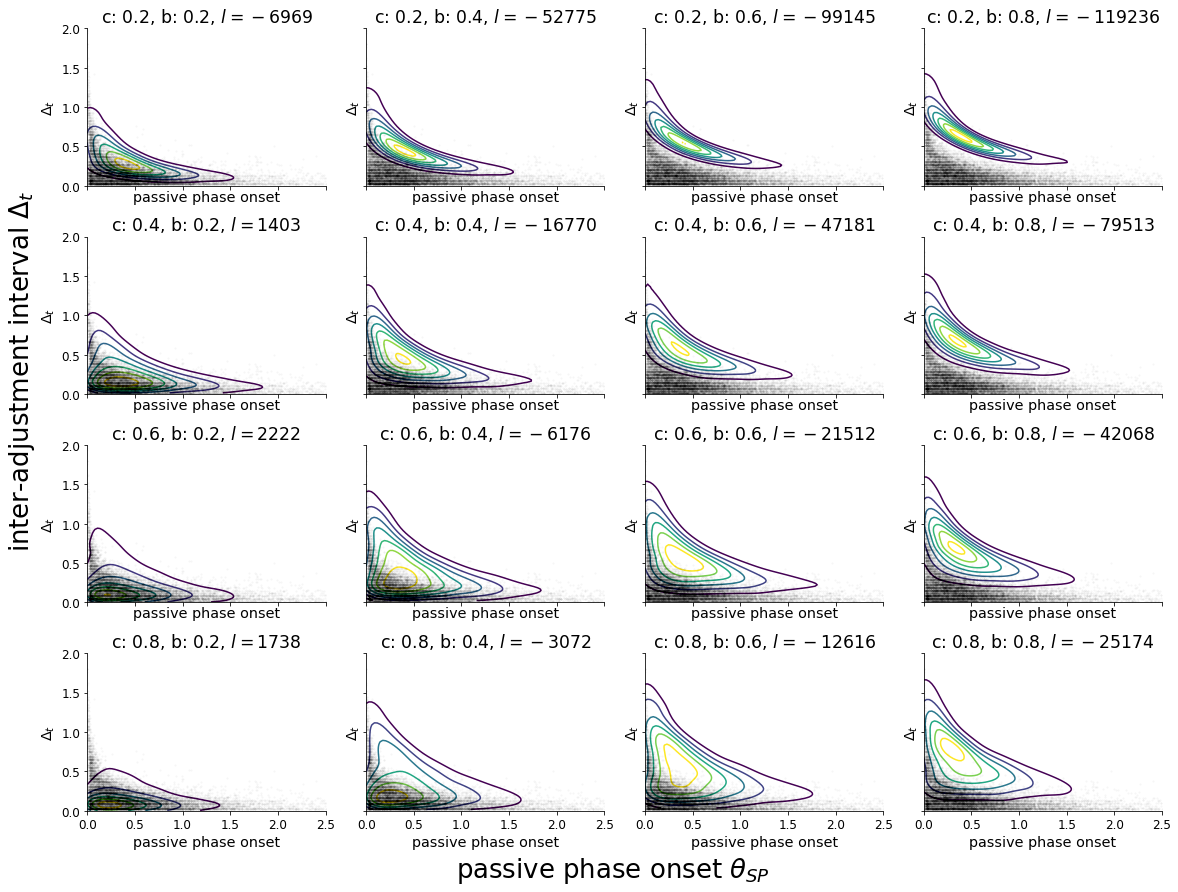

In [15]:
def plot_explore(filename, exp_data, grid):
    traj = Trajectory('DDM_stick')
    traj.f_load(filename=filename, index=-1, load_parameters=2, load_results=2)

    fig, axes = plt.subplots(grid, grid, figsize=(4*(grid),3*(grid)), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.reshape(-1)):        
        run = traj.f_get_run_names()[i]
        model_data = traj[run]
        
        plot_2d_hist(model_data.sp, model_data.delta_t, ax, show_data=False, cmap='viridis')        
        plot_2d_hist(exp_data.sp_scaled, exp_data.delta_t, ax, show_data=True, show_pdf=False, cmap='magma')
        ax.set_xlim((0.0, 2.5))
        ax.set_ylim((0.0001, 2.0))
        
        model_pdf = get_model_pdf(model_data)
        log_lik = get_log_likelihood(model_pdf, exp_data)
        f = '%.0f' % (log_lik)
        
        title = (traj.f_get_run_information(run)['parameter_summary'] + r', $l=%s$' % f).replace("  ", "")
        ax.set_title(title, )
            
    fig.text(0.37, -0.02, r'passive phase onset $\theta_{SP}$', fontsize=26)
    fig.text(-0.02, 0.75, r'inter-adjustment interval $\Delta_t$', fontsize=26, rotation=90)
    plt.tight_layout()

# plot_explore('ddm_ap_fixed_sp', 4)
# plot_explore('ddm_ap_uniform_sp', 4)
plot_explore(os.path.join(hdf_path, 'ddm_stick_ap_random_sp.hdf5'), exp_data, 4)

# Fixed decision threshold

In [ ]:
env = Environment(trajectory='DDM_AP',filename='./HDF/ddm_ap_fixed_threshold.hdf5', file_title='DDM_AP',overwrite_file=True)

traj = env.trajectory

traj.f_add_parameter('c', 1.0, comment='Diffusion rate')
traj.f_add_parameter('threshold', 1.0, comment='DDM threshold')
traj.f_add_parameter('theta_0', 'random', comment='Initial condition on theta')
traj.f_add_parameter('tau', 1.0, comment='Time scale of theta')

lin_grid_size = 5
# grid = np.logspace(-3, -1, 3).tolist() + [0.2, 0.4, 0.6, 0.8, 1.0]
# grid = np.logspace(-3, 2, 6).tolist()
grid = np.linspace(1, 10, 10).tolist()

traj.f_explore({'c' : grid})
# traj.f_explore(cartesian_product({'c':grid, 'threshold':grid}))
env.run(run_ddm)

Let's try plotting exp vs model data in the individual panels

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./HDF/ddm_ap_fixed_threshold.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `DDM_AP`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `2`.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


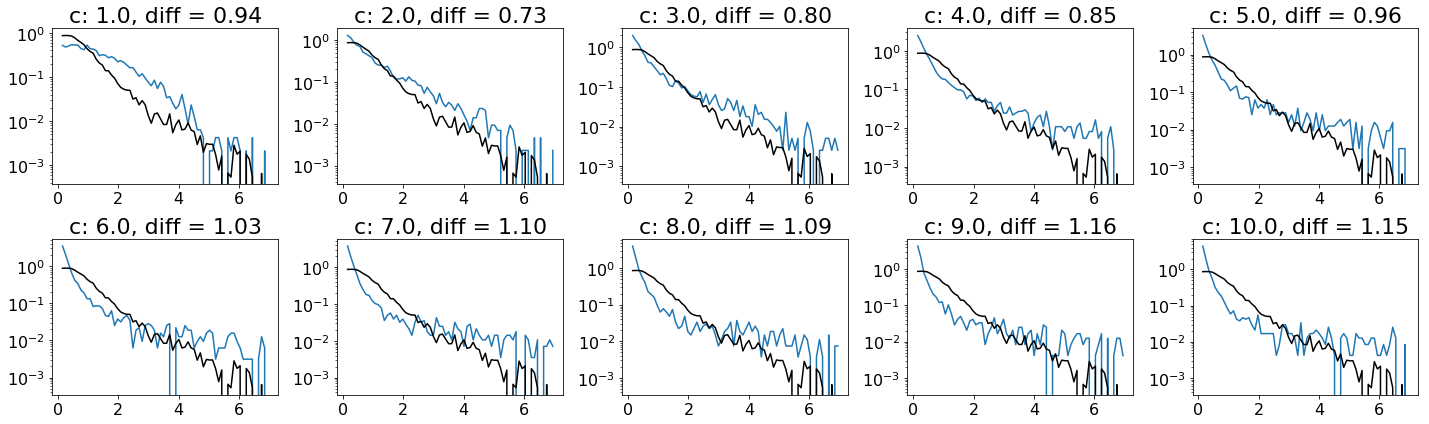

In [61]:
traj = Trajectory(filename='./HDF/ddm_ap_fixed_threshold.hdf5')
traj.f_load(index=-1, load_parameters=2, load_results=2)
exp_hist = pd.read_csv('stick_ap_distr_fast.csv', header=0, names=['bins', 'hist'])

fig, axes = plt.subplots(2, 5, figsize=(2*len(grid),6))

for i, ax in enumerate(axes.reshape(-1)):
#     print(i, ax)
    run = traj.f_get_run_names()[i]
    model_hist = traj[run]
    delta = abs(np.log(exp_hist['hist']) - np.log(model_hist.hist)).values
    f = np.nanmean(delta[~np.isinf(delta)])  if (np.mean(np.isinf(delta) | np.isnan(delta)) < 0.5) else 1000
    ax.plot((model_hist.bins[1:] + model_hist.bins[:-1])/2, model_hist.hist)
    ax.set_title(traj.f_get_run_information(run)['parameter_summary'] + ', diff = %.2f' % f)
    ax.plot(exp_hist['bins'], exp_hist['hist'], label='Stick data', color='k')
    ax.set_yscale('log')
plt.tight_layout()
plt.savefig('ddm_vs_stick_rand_end_fixed_th.png')

# Parameter fitting

Let's try to find optimal values of diffusion rate $c$ and threshold which together minimize deviation from the experimental histogram (log-scaled)

In [22]:
def f(x):
    c, b = x
    exp_hist = pd.read_csv('stick_ap_distr_fast.csv', header=0, names=['bin_centre', 'hist'])
    theta_0 = 'random'
    tau = 0.3
    xs = run_sim(c=c, b=b, theta_0=theta_0, tau=tau, n_trials=1000)
    ap = xs.groupby('n').last().theta
    bins = np.append(exp_hist['bin_centre'].values - 0.05, 7.0)
    model_hist, _ = np.histogram(ap/np.std(ap), bins=bins, normed=True)
    delta = abs(np.log(exp_hist['hist']) - np.log(model_hist)).values
    if (np.mean(np.isinf(delta) | np.isnan(delta)) > 0.5):
        f = 1000
    else:
        f = np.nanmean(delta[~np.isinf(delta)]) 
    return f

In [23]:
from scipy.optimize import minimize
res = minimize(f, [0.01, 0.01], bounds = [(0.001, 1), (0.001, 1)], method='L-BFGS-B')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [24]:
res

      fun: 0.8249237524630431
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-14217024.91280881,  -7326838.89696326])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 1
   status: 0
  success: True
        x: array([0.01000878, 0.01000878])

In [ ]:
from scipy.optimize import differential_evolution

bounds = [(0.001, 3), (0.001, 3)]
res_evol = differential_evolution(f, bounds, disp=True, maxiter=100, popsize=30)

In [10]:
res_evol

     fun: 0.7873175792711539
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 6108
     nit: 100
 success: False
       x: array([0.04439219, 0.02549289])

In [34]:
c = 0.053
threshold = 0.035
theta_0 = 0.01
tau = 0.3

In [32]:
c = 0.044
threshold = 0.023
theta_0 = 0.01
tau = 0.3

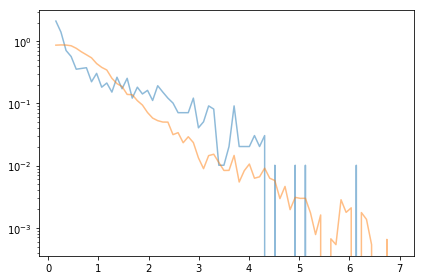

In [35]:
exp_hist = pd.read_csv('stick_ap_distr_fast.csv', header=0, names=['bin_centre', 'hist'])
xs = run_sim(c=c, threshold=threshold, theta_0=theta_0, tau=tau, n_trials=1000)
ap = xs.groupby('n').last().theta
bins = np.append(exp_hist['bin_centre'].values - 0.05, 7.0)
model_hist, _ = np.histogram(ap/np.std(ap), bins=bins, normed=True)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(exp_hist['bin_centre'], model_hist, label='Model', alpha=0.5)
ax.plot(exp_hist['bin_centre'], exp_hist['hist'], label='Stick data', alpha=0.5)
ax.set_yscale('log')
plt.tight_layout()

# Adding random starting point

This doesn't work as intended for some reason. First, sampling through rvs is very slow, second, the results don't seem to follow the sourse distribution

In [23]:
from scipy.stats import rv_continuous
from scipy import interpolate
import pandas as pd

class end_point_gen(rv_continuous):    
    def __init__(self, *args, **kwargs):
        self.end_hist = pd.read_csv('stick_end_point_distr.csv', header=0, names=['bin_left', 'hist'])
        self.f = interpolate.interp1d(self.end_hist['bin_left'], self.end_hist['hist'], fill_value=0, bounds_error=False)        
        super().__init__(*args, **kwargs)
    
    def _pdf(self, x):
        return self.f(x)

end_dist = end_point_gen(a=0, b=5)
end_dist.rvs(size=10)
# end_dist.pdf(x=1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


array([1.40636557, 5.        , 0.36811132, 0.10543283, 5.        ,
       0.27478318, 1.00446016, 5.        , 0.70460838, 0.15169176])

So far we can simply get random end-point from the actual values observed in the experiment

In [40]:
end_points = pd.read_csv('end_points.csv', header=0, names=['value'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


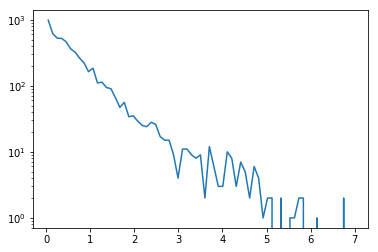

In [43]:
theta_lim = 6.0
hist_resolution = 0.1 #standard deviations per bin
bins_abs = np.linspace(0, theta_lim+1, (theta_lim+1)/hist_resolution)
hist, bins_abs = np.histogram(end_points, bins=bins_abs)
fig, ax = plt.subplots(1)
ax.plot((bins_abs[1:] + bins_abs[:-1])/2, hist)
ax.set_yscale('log')

# Parameter exploration (threshold)

In [3]:
dt = 0.005

def dtheta_threshold(theta, eps):
    return theta*dt + eps*np.random.randn()*np.sqrt(dt)
    
def run_trial_threshold(eps, threshold, theta_0, tau):
    t = [0]
    thetas = [theta_0]
    
    while thetas[-1] < threshold:
        theta = thetas[-1] + dtheta_threshold(thetas[-1], eps)/tau
        thetas.append(theta)        
        t.append(t[-1] + dt)        
                
    return np.array(t), np.array(thetas)

def run_sim_threshold(eps, threshold, theta_0, tau, n_trials=1000):
    trials = []
    for n in range(n_trials):
        if (theta_0) == 'random':
            ic = random.choice(end_points)[0]
        else:
            ic = theta_0                        
        t, theta = run_trial_threshold(eps, threshold, ic, tau)
        trials.append(pd.DataFrame(data={'n': n, 't': t, 'theta': theta}))
    return pd.concat(trials).set_index(['n'])
    
def run_threshold(traj):
    exp_hist = pd.read_csv('stick_ap_distr_fast.csv', header=0, names=['bin_centre', 'hist'])
    exp_bins = np.append(exp_hist['bin_centre'].values - 0.05, 7.0)
    xs = run_sim_threshold(eps=traj.eps, threshold=traj.threshold, theta_0='random', tau=traj.tau, n_trials=1000)
    ap = xs.groupby('n').last().theta
    hist = np.histogram(ap/np.std(ap), bins=exp_bins, normed=True)
    traj.f_add_result('hist', hist[0], comment='Histogram of action points')
    traj.f_add_result('bins', hist[1], comment='Bins of the histogram')

In [10]:
eps = 0.001
threshold = 0.01
dt = 0.005

# theta_0 = 0.001
theta_0 = 'random'
tau = 0.3

xs = run_sim_threshold(eps=eps, threshold=threshold, theta_0=theta_0, tau=tau, n_trials=5)
# run_trial_threshold(eps=eps, threshold=threshold, theta_0=theta_0, tau=tau)

In [1]:
env = Environment(trajectory='threshold_AP',filename='./HDF/threshold_ap.hdf5', file_title='threshold_AP',overwrite_file=True)

traj = env.trajectory

traj.f_add_parameter('eps', 0.01, comment='Noise intensity')
traj.f_add_parameter('threshold', 0.1, comment='Theta threshold')
traj.f_add_parameter('theta_0', 'random', comment='Initial condition on theta')
traj.f_add_parameter('tau', 0.3, comment='Time scale of theta')

lin_grid_size = 5
# grid = np.logspace(-3, -1, 3).tolist() + np.linspace(0.2, 1.0, lin_grid_size).tolist()
grid_eps = [0.001, 0.01, 0.1, 0.2, 0.3]
grid_threshold = [0.01, 0.1, 0.2, 0.3]

traj.f_explore(cartesian_product({'eps':grid_eps, 'threshold':grid_threshold}))

env.run(run_threshold)

NameError: name 'Environment' is not defined